In [1]:
import cv2
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras.applications import vgg16
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense

### Загрузка данных ###

In [6]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('C:/Cat and dog/train/*.jpg')
test_files = glob('C:/Cat and dog/test/*.jpg')
#shuffle(train_files)

print(train_files[1])

C:/Cat and dog/train\cat.1.jpg


### Визуализируем примеры для обучения ###

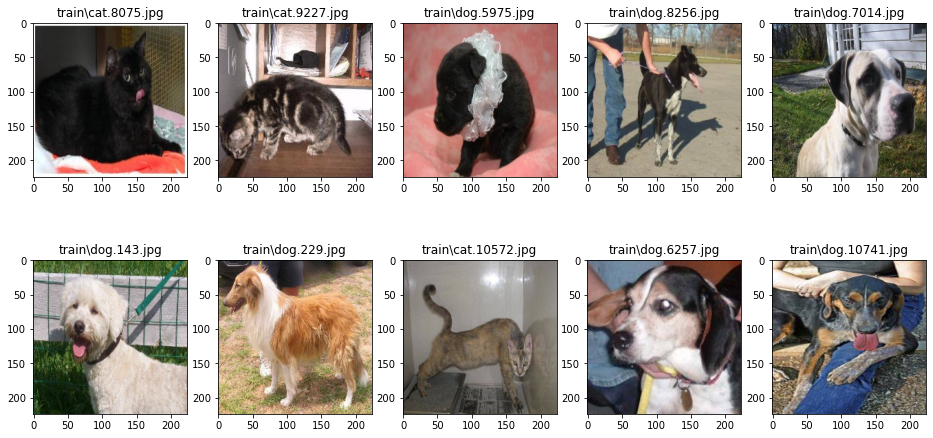

In [27]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

### Загружаем предобученную модель ###

In [3]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [5]:
base_model.trainable = False

### Создаем составную сеть ###

In [7]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

### Обучаем составную сеть на новом наборе данных ###

In [13]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam', 
              metrics = ['accuracy'])

### Функции загрузки данных ###

In [15]:
# загружаем входное изображение и предобрабатываем
def load_image(path, target_size = IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

### Компилируем модель и запускаем обучение ###

In [16]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

In [22]:
model.fit(
    train_data,
    steps_per_epoch = 270,
    epochs = 2,
    validation_data = validation_data)

Epoch 1/2
270/270 [==============================] - 2771s 10s/step - loss: 0.5132 - accuracy: 0.9649 - val_loss: 8.7390e-04 - val_accuracy: 1.0000
Epoch 2/2
270/270 [==============================] - 3741s 14s/step - loss: 0.1213 - accuracy: 0.9686 - val_loss: 0.0815 - val_accuracy: 1.0000


In [23]:
model.save('cats-dogs-vgg16.hdf5')

### Предсказания на проверочной выборке ###

In [25]:
test_pred = model.predict(predict_generator(test_files), steps=len(test_files))

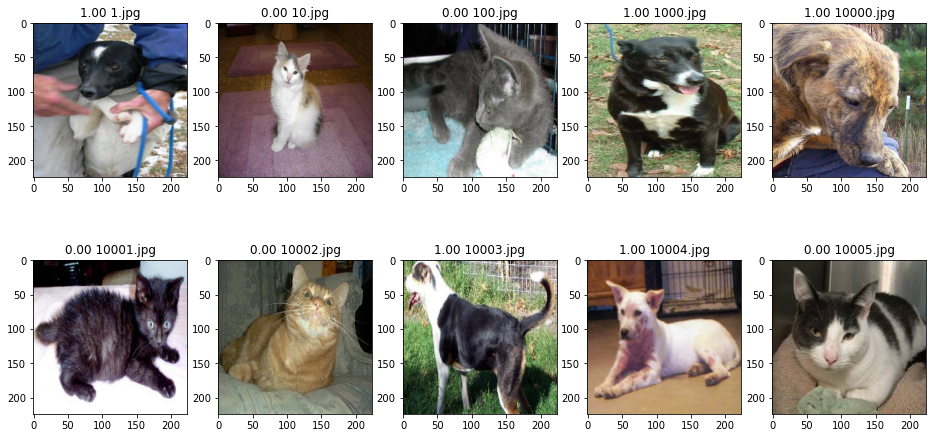

In [28]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

### Готовим данные для отправки ###

In [33]:
import re

with open('C:/Programming/decision1.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))